In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import penne

In [98]:
dataset = 'mdb'
stem = '000159'

# Load from cache
directory = penne.CACHE_DIR / dataset
audio = np.load(directory / f'{stem}-audio.npy')
pitch = np.load(directory / f'{stem}-pitch.npy')
voiced = np.load(directory / f'{stem}-voiced.npy')

# Convert to torch
audio = torch.from_numpy(audio)[None]
pitch = torch.from_numpy(pitch)
voiced = torch.from_numpy(voiced)

# Convert to pitch bin categories
bins = penne.convert.frequency_to_bins(pitch)

# Set unvoiced bins to random values
bins = torch.where(
    ~voiced,
    torch.randint(0, penne.PITCH_BINS, bins.shape, dtype=torch.long),
    bins)

# Infer
predicted_pitch, predicted_periodicity, logits, frames = penne.from_audio(
    audio[:, :],
    penne.SAMPLE_RATE,
    model='crepe',
    checkpoint=penne.RUNS_DIR / 'crepe' / '00250000.pt',
    batch_size=2048,
    gpu=0)

In [93]:
offset = (penne.WINDOW_SIZE - penne.HOPSIZE) // 2
parts = \
    [frames[:, :offset + penne.HOPSIZE, 0]] + \
    [frames[:, offset:offset + penne.HOPSIZE, i] for i in range(1, frames.shape[-1] - 1)] + \
    [frames[:, -offset + penne.HOPSIZE:, -1]]
reconstructed = torch.cat(parts, dim=1)

torch.Size([1, 1024, 7573])


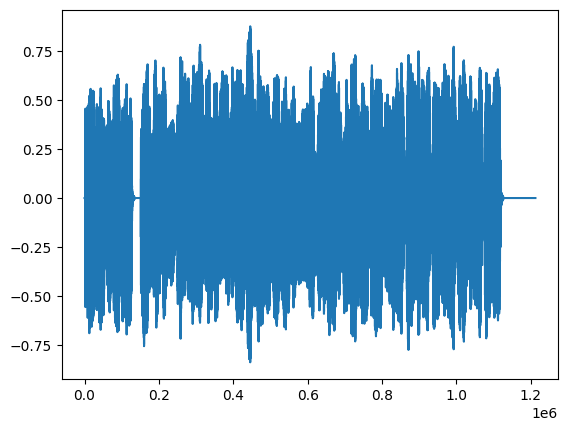

In [97]:
plt.plot(reconstructed.cpu().squeeze())

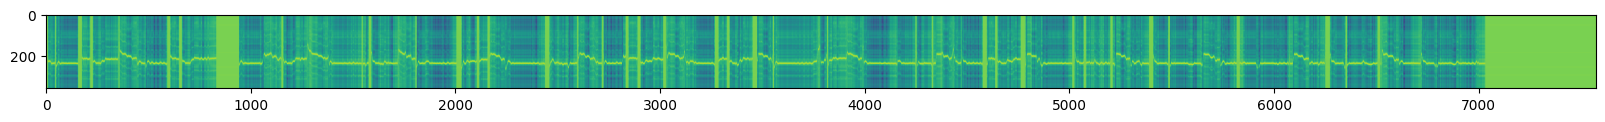

In [99]:
plt.figure(figsize=(20, 20))
logits[logits < -80.] = -80.
plt.imshow(logits.squeeze()[:, :])

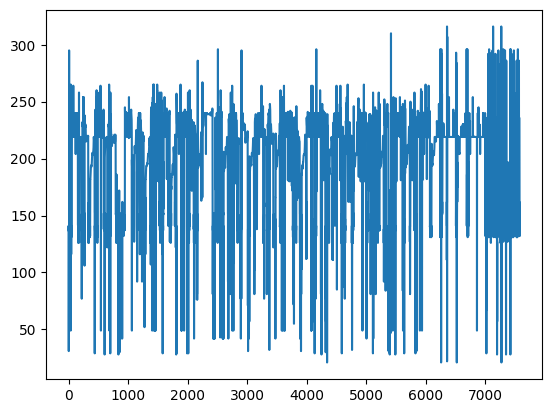

In [33]:
plt.plot(logits.max(dim=1).indices.squeeze())

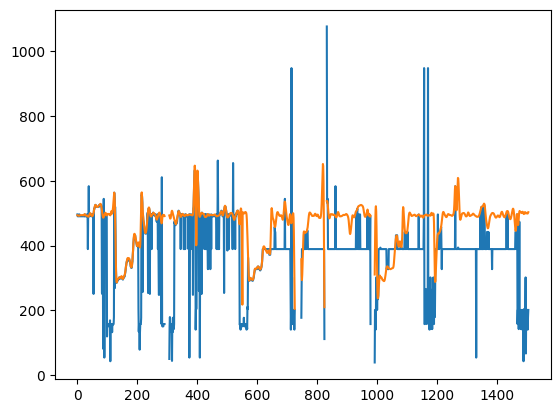

In [45]:
pitch[~voiced] = np.nan
predicted_pitch[:, ~voiced] = np.nan
start, end = -2048, -1
plt.plot(predicted_pitch.squeeze()[start:end])
plt.plot(pitch.squeeze()[start:end])


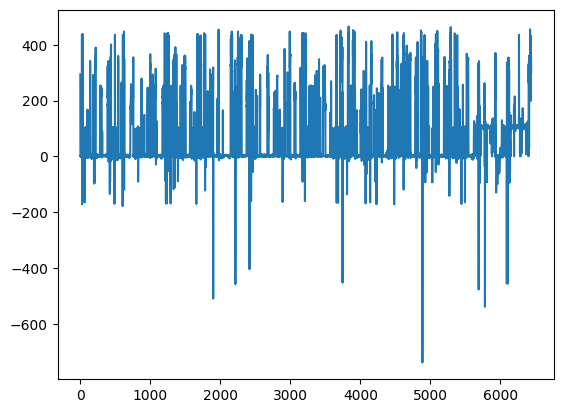

In [37]:
plt.plot(pitch[voiced].squeeze() - predicted_pitch.squeeze()[voiced])